# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.special import erf
from scipy.special import erfinv
from scipy.spatial import ConvexHull
from astropy.io import fits
from time import time as time

from numba import njit
from photutils import segmentation as segm

*TODO*: Properly support repeated values (infinite density)

In [2]:
class SortedData(object):
    
    def __init__(self, data, nbins=None):
        
        t0 = time()
        self.original = data.view()
        self.size = data.size
        self.strides = np.array(data.strides) // data.itemsize
        self.flat = data.ravel()

        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        self.arg_sorted = np.argsort(self.flat)
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        self.sorted = self.flat[self.arg_sorted]
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        valid = np.isfinite(self.sorted)
        self.arg_sorted = self.arg_sorted[valid]
        self.sorted = self.sorted[valid]
        self.n_valid = self.sorted.size
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        
        self.x_rho, self.rho = self.probability_density()
        weight = self.rho**2
        self.mode = np.sum(self.x_rho*weight) / np.sum(weight)
        self.index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        self.bg_std = np.sqrt(np.mean((self.sorted[:self.index_mode] - self.mode)**2))
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()

        self.rho_symmetric =  np.interp(2*self.mode-self.x_rho, self.x_rho, self.rho, left=0, right=0)
        self.bg_fraction = np.clip(self.rho_symmetric/self.rho, 0, 1)
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()
        
        self.n_signal = self.n_valid - 2*self.index_mode
        #self.n_signal = self.n_valid - self.index_mode
        self.threshold = self.sorted[-self.n_signal]
        self.contamination = np.count_nonzero(self.sorted < 2*self.mode-self.threshold)
        self.purity = 1 - self.contamination/self.n_signal
        self.completeness = 1 - self.contamination/self.n_signal
        print(f'time elapsed: {time()-t0:.3g} s'); t0 = time()

        
    '''
    def find_threshold(self, intermediate_purity_threshold=0.5):
        
        index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        n_above_mode = self.n_valid - index_mode
        n_signal = n_above_mode - index_mode

        #threshold = 2*data.mode - data.sorted[index_mode-1::-1]
        total_above_threshold = np.interp(2*data.mode-data.sorted[index_mode-1::-1], data.sorted[index_mode:], n_above_mode-np.arange(n_above_mode))
        #bg_above_threshold = index_mode - np.arange(index_mode)
        #signal_above_threshold = total_above_threshold - bg_above_threshold

        #completeness = signal_above_threshold / n_signal
        #purity = signal_above_threshold / total_above_threshold
        # completeness > purity: 
        index_mode = np.searchsorted(self.sorted, self.mode, side='right')
        index_max = np.searchsorted(self.sorted, 2*self.mode-self.sorted[0], side='right')
        #n_above_mode = 
        n_intermediate = index_max - index_mode
        n_src = n_intermediate - index_mode
        print(f'{n_intermediate} values between mode ({self.mode:.3g}) and symmetric minimum ({2*self.mode-self.sorted[0]:.3g})')

        M_bg_above = np.interp(2*self.mode-self.sorted[index_mode:index_max], self.sorted[:index_mode], np.arange(index_mode), 0, index_mode)
        # purity in the intermediate range (th) = 1 - M_bg(th<x<xmax) / M(mode<x<xmax) < intermediate_purity_threshold:
        condition = M_bg_above > (n_intermediate - np.arange(n_intermediate)) * (1-intermediate_purity_threshold)
        return np.max(self.sorted[index_mode:index_max][condition])

        reliable_probability = np.min(self.bg_fraction[self.x_rho < self.mode])
        return np.max(self.x_rho[self.bg_fraction > reliable_probability])
        #self.bg_fraction[self.x_rho < self.threshold] = 1
    '''
        
    def probability_density(self):
        
        nbins = int(np.sqrt(4*self.n_valid + 1) - 1)

        bins_m = np.arange(nbins+1)
        bins_m = bins_m*(bins_m+1)//2
        half = bins_m.size // 2
        bins_m[bins_m.size-half:] = self.n_valid-1 - bins_m[half-1::-1]
        bins_x = self.sorted[bins_m]

        x = (bins_x[1:] + bins_x[:-1]) / 2
        rho = (bins_m[1:] - bins_m[:-1]) / (bins_x[1:] - bins_x[:-1])
        # median filter:
        #rho = np.nanmedian(np.vstack([rho[:-2], rho[1:-1], rho[2:]]), axis=0)
        #x = np.hstack([self.sorted[0], x[1:-1], self.sorted[-1]])
        #rho = np.hstack([1/(self.sorted[1]-self.sorted[0]), rho, 1/(self.sorted[-1]-self.sorted[-2])])

        return x, rho/self.n_valid

    
    def compute_p_normal(self):

        a_x, a_hist = self.probability_density()
        left = np.where(a_x < self.x0)
        x_sym = 2*self.x0-a_x[left]
        f_normal = np.clip(a_hist[left]/np.interp(x_sym, a_x, a_hist), 0, 1)
        p_normal = np.interp(self.original, x_sym[::-1], f_normal[::-1], left=1, right=0)

        return p_normal
    

## 2. Read data

### select one dataset:

In [3]:
dataset = 2

In [4]:
plots = False

In [5]:
plots = True

1D spectra

2D images:

In [6]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [7]:
if dataset == 2:
    object_name = 'CIG 335'
    hdu = fits.open('data/CIG_335.fits')
    data = SortedData(hdu[0].data[3000:4000, 1500:2500].astype(np.float32))

time elapsed: 4.96e-05 s
time elapsed: 0.168 s
time elapsed: 0.00471 s
time elapsed: 0.00715 s
time elapsed: 0.00271 s
time elapsed: 0.000265 s
time elapsed: 0.0111 s


3D datacubes:

In [8]:
if dataset == 3:
    object_name = 'HGC 44'
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = SortedData(hdu[0].data.astype(np.float32))

In [9]:
if dataset == 4:
    hdu = fits.open('data/sofiawsrtcube.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

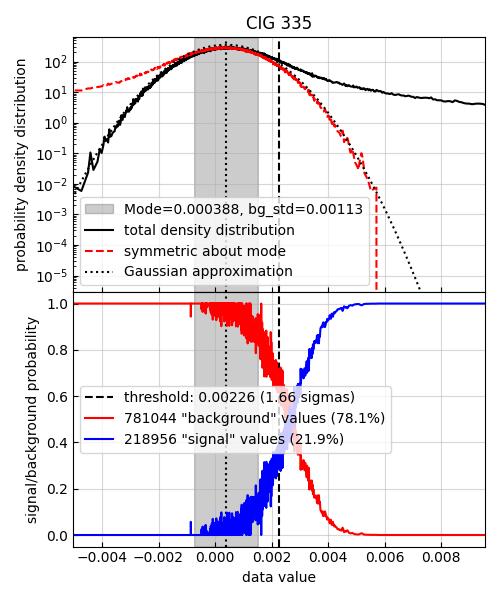

In [10]:
if plots:
    plt.close('density')
    fig = plt.figure('density', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(data.mode, c='k', ls=':')
        shade = axis.fill_between(data.x_rho, 0, 1, where=np.abs(data.x_rho-data.mode) <= data.bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={data.mode:.3g}, bg_std={data.bg_std:.3g}')
        th_line = axis.axvline(data.threshold, c='k', ls='--')
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('probability density distribution')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(data.rho[data.x_rho > data.mode]), 2*np.max(data.rho))
    ax[0, 0].plot(data.x_rho, data.rho, 'k-', label='total density distribution')
    ax[0, 0].plot(data.x_rho, data.rho_symmetric, 'r--', label='symmetric about mode')
    ax[0, 0].plot(data.x_rho,
                  np.exp(-.5*((data.x_rho-data.mode)/data.bg_std)**2) * data.n_valid/data.size/np.sqrt(2*np.pi)/data.bg_std,
                  'k:', label='Gaussian approximation')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('signal/background probability')
    #ax[1, 0].set_yscale('log')
    #ax[1, 0].set_ylim(np.min(reliable_signal_probability), 1.5)
    ax[1, 0].plot(data.x_rho, data.bg_fraction, 'r-',
                  label=f'{2*data.index_mode} "background" values ({200*data.index_mode/data.n_valid:.1f}%)')
    ax[1, 0].plot(data.x_rho, 1-data.bg_fraction, 'b-',
                  label=f'{data.n_signal} "signal" values ({100*data.n_signal/data.n_valid:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {data.threshold:.3g} ({(data.threshold-data.mode)/data.bg_std:.3g} sigmas)')
    ax[1, 0].legend(loc='center left')

    ax[-1, 0].set_xlim(data.sorted[0], 2*data.threshold-data.sorted[0])
    ax[-1, 0].set_xlabel('data value')


    dummy = np.interp(data.sorted[index_mode:], 2*data.mode-data.sorted[index_mode-1::-1], index_mode-np.arange(index_mode), index_mode, 0)
$$ M_{bg}(>x) $$
$$ M_{src}(>x) = M(>x) - M_{bg}(>x) $$

$$ M_{src}(<x) = [M(<x)-M(x_0)] - [M_{bg}(<x)-M_{bg}(x_0)] = M(<x) - M_{bg}(<x_0) $$

Contamination: $M_{bg}(>x)$

Purity: $P(x) = \frac{ M_{src}(>x) }{ M(>x) } = 1 - \frac{ M_{bg}(>x) }{ M(>x) }$

Completeness: $C(x) = \frac{ M_{src}(>x) }{ M_{src} } = \frac{ M(>x) }{ M_{src} } P(x) $

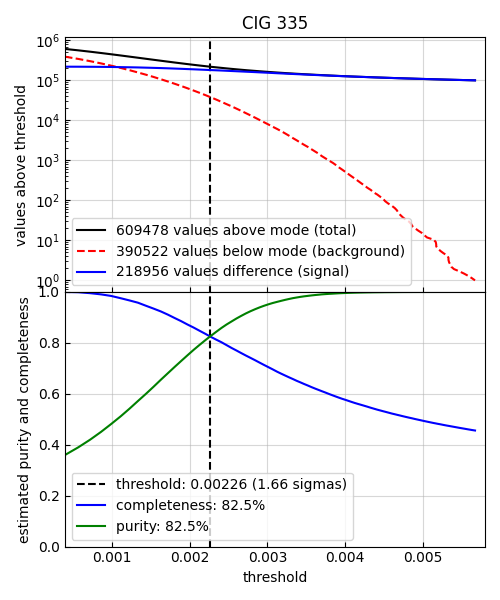

In [11]:
if plots:
    plt.close('completeness-purity')
    fig = plt.figure('completeness-purity', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        th_line = axis.axvline(data.threshold, c='k', ls='--')
    fig.set_tight_layout(True)


    index_mode = np.searchsorted(data.sorted, data.mode, side='right')
    n_above_mode = data.n_valid - index_mode
    n_signal = data.n_valid - 2*index_mode
    
    bg_above_threshold = np.logspace(0, np.log10(index_mode), 100)
    threshold = 2*data.mode - np.interp(bg_above_threshold, np.arange(index_mode), data.sorted[:index_mode])
    bg_above_threshold = bg_above_threshold[::-1]
    threshold = threshold[::-1]
    total_above_threshold = np.interp(threshold, data.sorted[index_mode:], n_above_mode-np.arange(n_above_mode))
    signal_above_threshold = total_above_threshold - bg_above_threshold

    completeness = signal_above_threshold / n_signal
    purity = signal_above_threshold / total_above_threshold
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('values above threshold')
    ax[0, 0].set_yscale('log')
    ax[0, 0].plot(threshold, total_above_threshold, 'k-', label=f'{n_above_mode} values above mode (total)')
    ax[0, 0].plot(threshold, bg_above_threshold, 'r--', label=f'{index_mode} values below mode (background)')
    ax[0, 0].plot(threshold, signal_above_threshold, 'b-', label=f'{n_above_mode-index_mode} values difference (signal)')
    th_line.set_label(f'threshold: {data.threshold:.3g} ({(data.threshold-data.mode)/data.bg_std:.3g} sigmas)')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('estimated purity and completeness')
    ax[1, 0].plot(threshold, completeness, 'b-', label=f'completeness: {100*data.completeness:.1f}%')
    ax[1, 0].plot(threshold, purity, 'g-', label=f'purity: {100*data.purity:.1f}%')
    ax[1, 0].legend()
    ax[1, 0].set_ylim(0, 1)

    ax[-1, 0].set_xlim(data.mode, 2*data.mode-data.sorted[0])
    ax[-1, 0].set_xlabel('threshold')


In [12]:
data_dimensionality = len(data.strides)
colour_scale = colors.SymLogNorm(vmin=data.sorted[0],
                                 #linthresh=data.threshold,
                                 linthresh=2*data.mode-data.sorted[0],
                                 vmax=data.sorted[-1])

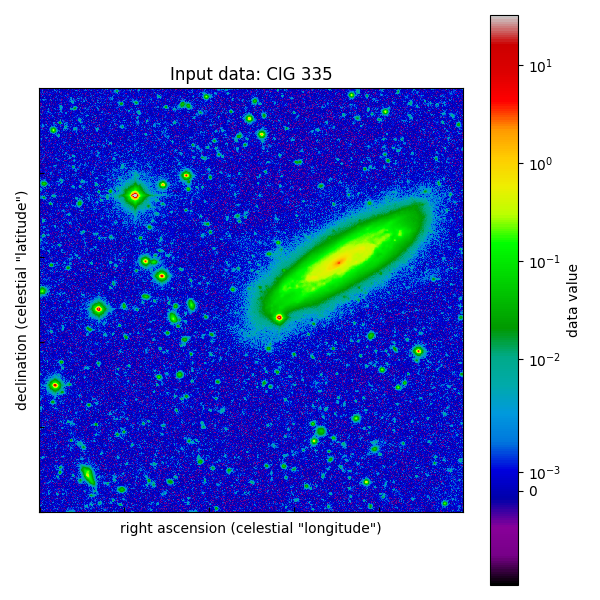

In [13]:
if plots and data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data', figsize=(6, 6))
    ax = fig.subplots()
    ax.tick_params(which='both', direction='in')
    fig.set_tight_layout(True)

    im = ax.imshow(data.original,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral', norm=colour_scale,
                  )
    ax.set_title('Input data: CIG 335')
    ax.set_ylabel('declination (celestial "latitude")')
    ax.set_xlabel('right ascension (celestial "longitude")')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    #ax.contour(data.original, levels=[reliable_x], colors=['w'])
    #ax.contour(data.original, levels=[2*data.mode-data.sorted[0]], colors=['w'])
    #ax.contour(data.original, levels=[data.threshold], colors=['k'])
    #ax.contour(data.original, levels=[2*data.mode-data.threshold], colors=['k'])
    cb = fig.colorbar(im, ax=ax)
    #cb.ax.axhline(2*data.mode-data.sorted[0], c='w')
    #cb.ax.axhline(data.threshold, c='k')
    #cb.ax.axhline(2*data.mode-data.threshold, c='k', ls='--')
    cb.ax.set_ylabel('data value')
    plt.show()

In [14]:
if plots and data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    #lo = np.nanpercentile(data, 70)
    #hi = np.nanpercentile(data, 99)
    #lo = .75*rms
    #hi = 1.25*rms
    lo = .5*rms
    hi = 2*rms
    rms = np.sqrt(np.nanmean(data.original**2))
    #colour_scale = colors.SymLogNorm(vmin=0, linthresh=rms/np.sqrt(np.mean(data.shape)), vmax=np.nanmax(data))
    colour_scale = colors.SymLogNorm(vmin=0, linthresh=2*rms, vmax=10*rms)
    
    ax[0, 0].set_title('Input data (rms value along projected axis)')
    im = ax[0, 0].imshow(np.sqrt(np.nanmean(data.original**2, axis=0)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                         #vmin=lo, vmax=hi,
                  )
    ax[0, 0].set_ylabel('declination (celestial "latitude")')

    #ax[0, 1].set_title('Input data (rms value along declination axis)')
    im = ax[0, 1].imshow(np.sqrt(np.nanmean(data.original**2, axis=2)).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                         #vmin=lo, vmax=hi,
                  )
    ax[0, 1].set_xlabel('frequency channel')
    #ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(data.original**2, axis=1)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                         vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_xlabel('right ascension (celestial "longitude")')
    ax[1, 0].set_ylabel('frequency channel')
    #ax[1, 0].set_aspect('auto')
    
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    cb = fig.colorbar(im, ax=ax[1, 1], orientation='horizontal')
    cb.ax.set_title(r'$I_{rms}(x, y) = \sqrt{\frac{1}{N_z} \sum_z I^2(x,y,z)}$')
    ax[1, 1].set_visible(False)
    plt.show()

## 3. Hierarchical Overdensity Tree (HOT)

### routine definition:

$$ S = \sum p_i (I_i - I_0) $$
$$ \sigma^2 = 2\sigma_0^2 \sum p_i $$

$$ n = \sum p_i $$
$$ \Delta S_n = p_n I_n + (n-1) I_{n-1} - n I_n = (p_n - 1) I_n + (n-1) (I_{n-1}-I_n) $$
$$ \Delta S_n > 0 ~~ \iff ~~ I_n < \frac{n-1}{1-p_n} I_{n-1} ~;~ 1-p_n < (n-1) \frac{I_{n-1}}{I_n} $$

$$ \Delta \sigma^2_i = p_i 2\sigma_0^2 $$

$$ \Delta \ln(S/N)^2 \sim \frac{(S+\Delta S)^2}{\sigma^2 + \Delta \sigma^2 } \frac{\sigma^2}{S^2} $$
$$ \propto \frac{S^2+p^2I^2+2pI}{1 + p } $$

$$
(S/N)^2_{a+b} = \frac{ (S_a + S_b)^2 }{ \sigma^2_a + \sigma^2_b }
= \frac{ \sigma^2_a\frac{S^2_a}{\sigma^2_a} + \sigma^2_b\frac{S^2_b}{\sigma^2_b}
        + 2 \sigma_a\sigma_b\frac{S_a}{\sigma_a}\frac{S_b}{\sigma_b} }{ \sigma^2_a + \sigma^2_b }
$$ 

Otsu:
$$
\sigma_{w}^{2}(t)
= \omega_{0}(t)\sigma_{0}^{2}(t)+\omega_{1}(t)\sigma_{1}^{2}(t)
= \sum_0 (x-\mu_0)^2 + \sum_1 (x-\mu_1)^2
= \sum x^2 + \omega_0\mu_0^2 + \omega_1\mu_1^2 -2\mu_0\sum_0 x -2\mu_1\sum_1 x
= \sum x^2 - \omega_0\mu_0^2 - \omega_1\mu_1^2
$$

Yago, $H_0$ (object is background):
$$
\sigma^2 = \sigma_{bg}^2 \pm \frac{\sigma_{bg}^2}{N-1}
$$
$$
\mathcal{L}(H_0) = \sqrt{\frac{N-1}{2\pi\sigma_{bg}^2}} \exp\left( -\frac{(N-1)(\sigma-\sigma_{bg})^2}{2\sigma_{bg}^2} \right)
$$

$$
\langle \sum (x-\mu)^2 \rangle
= \langle \sum (x^2 + \mu^2 - 2x\mu) \rangle
= N (\mu^2 + \sigma^2) + N\mu^2 - 2N\mu^2
= N\sigma^2
$$

$$
\langle (\sqrt{\frac{1}{N}\sum (x-\mu)^2} - \sigma)^2\rangle
= ...
$$


In [15]:
@njit
def hot(data, sorted_strides, argsorted_data, inverted=False, n_pixels=0):
    """Hierarchical Overdenity Tree (HOT)"""

    dimensions = len(data.strides)
    flat_data = data.ravel()
    
    label = np.zeros(data.size, dtype=np.int32)
    n_labels = 0
    
    n_peaks_max = 1 + data.size//2**dimensions  # maximum number of peaks
    parent = np.zeros(n_peaks_max, dtype=np.int32)
    area = np.zeros(n_peaks_max, dtype=np.int32)
    sum_value = np.zeros(n_peaks_max, dtype=np.float64)
    sum_sqare_value = np.zeros(n_peaks_max, dtype=np.float64)
    #max_signal_to_noise = np.zeros(n_peaks_max, dtype=np.float32)
    #signal_to_noise_area = np.zeros(n_peaks_max, dtype=np.int32)

    if inverted:
        sorted_index = 0  # minimum
        direction = 1
    else:
        sorted_index = argsorted_data.size  # maximum
        direction = -1
    if n_pixels <= 0:
        n_pixels = argsorted_data.size

    pixels_so_far = 0

    while pixels_so_far < n_pixels:
        pixel = argsorted_data[sorted_index]
        pixel_value = flat_data[pixel]
        pixels_so_far += 1
        sorted_index += direction

        neighbour_parents = []
        for dim in range(dimensions):
            stride = sorted_strides[dim]
            remainder = pixel % sorted_strides[dim+1]  # Remember DIRTY HACK 1? ;^D
            if remainder >= stride:  # not at the "left border"
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if remainder < sorted_strides[dim+1]-stride:  # not at the "right border"
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent

        label[pixel] = selected_parent
        area[selected_parent] += 1
        sum_value[selected_parent] += pixel_value
        sum_sqare_value[selected_parent] += pixel_value**2
        #n = area[selected_parent]
        #signal_to_noise = (sum_value[selected_parent] - n*smoothed_pixel_value) / np.sqrt(n)
        #if signal_to_noise > max_signal_to_noise[selected_parent]:
        #    max_signal_to_noise[selected_parent] = signal_to_noise
        #    signal_to_noise_area[selected_parent] = n
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               #sum_value[:n_labels+1],
               #sum_sqare_value[:n_labels+1],
               np.sqrt((sum_sqare_value[:n_labels+1]/area[:n_labels+1] - (sum_value[:n_labels+1]/area[:n_labels+1])**2) * (area[:n_labels+1] - 1)),
               #max_signal_to_noise[:n_labels+1],
               #signal_to_noise_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### selection based on inverted image:

In [16]:
'''
t0 = time()
label, catalog_inv = hot(smoothed_data.mode-data,
                         smoothed_data.mode-smoothed_data,
                         dummy_argsort[::-1],
                         HOT_threshold)
#parent_inv = catalog_inv[0]
#area_inv = catalog_inv[1]
max_signal_to_noise_inv = catalog_inv[2]
signal_to_noise_area_inv = catalog_inv[3]
print(f'time elapsed: {time()-t0:.3g} s')
'''

"\nt0 = time()\nlabel, catalog_inv = hot(smoothed_data.mode-data,\n                         smoothed_data.mode-smoothed_data,\n                         dummy_argsort[::-1],\n                         HOT_threshold)\n#parent_inv = catalog_inv[0]\n#area_inv = catalog_inv[1]\nmax_signal_to_noise_inv = catalog_inv[2]\nsignal_to_noise_area_inv = catalog_inv[3]\nprint(f'time elapsed: {time()-t0:.3g} s')\n"

In [17]:
t0 = time()

label, catalog_inv = hot(data.original,
                         np.hstack([np.sort(data.strides), data.size]), # DIRTY HACK when testig particles at the boundary
                         data.arg_sorted,
                         inverted=True,
                         n_pixels=data.contamination,
                         #n_pixels=data.index_mode,
                        )
area_inv = catalog_inv[1]
test_stat_inv = catalog_inv[2]/np.std(data.sorted[:index_mode])
print(f'time elapsed: {time()-t0:.3g} s')

31597 overdensities found: 38306 "pixels" (3%), 31022 independent regions
time elapsed: 4.22 s


Compute the upper hull of the inverted catalogue:

In [18]:
'''
t0 = time()


def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]

good_hull = (signal_to_noise_area_inv > 0) & (signal_to_noise_area_inv < np.nanmax(signal_to_noise_area_inv))
log_area_inv = np.log(signal_to_noise_area_inv[good_hull])
signal = max_signal_to_noise_inv[good_hull]
signal_hull_x, signal_hull_y = upper_hull(log_area_inv, signal)
'''
print(f'time elapsed: {time()-t0:.3g} s')

time elapsed: 12.9 s


### analysis of the normal image:

In [19]:
'''
t0 = time()
#label, catalog = hot((data-data.mode)/bg_std, dummy_argsort, HOT_threshold)
#label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, threshold_guess)
#label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, smoothed_threshold_guess)
label, catalog = hot(data-smoothed_data.mode,
                     smoothed_data-smoothed_data.mode,
                     dummy_argsort,
                     HOT_threshold)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_signal_to_noise = catalog[2]
signal_to_noise_area = catalog[3]
print(f'time elapsed: {time()-t0:.3g} s')
'''

"\nt0 = time()\n#label, catalog = hot((data-data.mode)/bg_std, dummy_argsort, HOT_threshold)\n#label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, threshold_guess)\n#label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, smoothed_threshold_guess)\nlabel, catalog = hot(data-smoothed_data.mode,\n                     smoothed_data-smoothed_data.mode,\n                     dummy_argsort,\n                     HOT_threshold)\nsegmentation = segm.SegmentationImage(label)\nparent = catalog[0]\narea = catalog[1]\nmax_signal_to_noise = catalog[2]\nsignal_to_noise_area = catalog[3]\nprint(f'time elapsed: {time()-t0:.3g} s')\n"

In [20]:
t0 = time()

label, catalog = hot(data.original,
                     np.hstack([np.sort(data.strides), data.size]), # DIRTY HACK when testig particles at the boundary
                     data.arg_sorted,
                     inverted=False,
                     n_pixels=data.n_signal,
                     #n_pixels=data.n_valid-data.index_mode,
                    )
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]/np.std(data.sorted[:index_mode])
print(f'time elapsed: {time()-t0:.3g} s')

56191 overdensities found: 218956 "pixels" (21%), 35395 independent regions
time elapsed: 0.168 s


### selectrion criterion:

In [21]:
'''
if plots:
    plt.close('reliability')
    fig = plt.figure('reliability')
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    sorted_test_stat_inv = np.sort(test_stat_inv[test_stat_inv > 0])
    n_inv = sorted_test_stat_inv.size
    f_inv_above = 1 - np.arange(n_inv)/n_inv
    
    sorted_test_stat = np.sort(test_stat[test_stat > 0])
    n = sorted_test_stat.size
    f_above = 1 - np.arange(n)/n
    f_above_interp = np.interp(sorted_test_stat_inv, sorted_test_stat, f_above)
    bg_fraction = np.min(f_above_interp/f_inv_above)
    signal_fraction = np.max(f_above_interp - bg_fraction*f_inv_above)
    bg_fraction = 1 - signal_fraction
    signal = (f_above_interp - bg_fraction*f_inv_above)
    completeness = signal/np.max(signal)
    purity = signal/f_above_interp
    #selection_threshold = np.max(sorted_test_stat_inv[completeness > purity])
    #selection_threshold = np.interp(bg_fraction, 1-f_above_interp, sorted_test_stat_inv)
    selection_threshold = np.max(sorted_test_stat_inv)

    ax[0, 0].set_ylabel('fraction of objects above')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_xscale('log')
    ax[0, 0].plot(sorted_test_stat_inv, bg_fraction*f_inv_above, 'r-')
    ax[0, 0].plot(sorted_test_stat_inv, signal, 'b-')
    ax[0, 0].plot(sorted_test_stat, f_above, 'k-')
    ax[0, 0].axvline(selection_threshold, c='k', ls='--')
    ax[0, 0].axhline(signal_fraction, c='b', ls=':')

    ax[1, 0].set_ylabel('purity and completeness')
    ax[1, 0].plot(sorted_test_stat_inv, completeness, 'b-', label=f'completeness: {100*data.completeness:.1f}%')
    ax[1, 0].plot(sorted_test_stat_inv, purity, 'g-', label=f'purity: {100*data.purity:.1f}%')
    ax[1, 0].legend()
    ax[1, 0].set_ylim(0, 1)
    #ax[1, 0].set_yscale('log')
    ax[1, 0].axvline(selection_threshold, c='k', ls='--')
   
    ax[-1, 0].set_xlabel('test statistic')
'''

"\nif plots:\n    plt.close('reliability')\n    fig = plt.figure('reliability')\n    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,\n                      sharex=True, sharey='row',\n                      gridspec_kw={'hspace': 0, 'wspace': 0})\n    for axis in ax.flatten():\n        axis.tick_params(which='both', direction='in')\n        axis.grid(alpha=.5)\n    fig.set_tight_layout(True)\n\n    sorted_test_stat_inv = np.sort(test_stat_inv[test_stat_inv > 0])\n    n_inv = sorted_test_stat_inv.size\n    f_inv_above = 1 - np.arange(n_inv)/n_inv\n    \n    sorted_test_stat = np.sort(test_stat[test_stat > 0])\n    n = sorted_test_stat.size\n    f_above = 1 - np.arange(n)/n\n    f_above_interp = np.interp(sorted_test_stat_inv, sorted_test_stat, f_above)\n    bg_fraction = np.min(f_above_interp/f_inv_above)\n    signal_fraction = np.max(f_above_interp - bg_fraction*f_inv_above)\n    bg_fraction = 1 - signal_fraction\n    signal = (f_above_interp - bg_fraction*f_inv_above)\n    completen

In [22]:
ts = SortedData(test_stat[test_stat > 0])
ts_inv = SortedData(test_stat_inv[test_stat_inv > 0])
#ts = SortedData(test_stat)
#ts_inv = SortedData(test_stat_inv)

ts_rho_interp = np.interp(ts_inv.x_rho, ts.x_rho, ts.rho)
selection_threshold = np.max(ts_inv.x_rho[ts_inv.rho >= ts_rho_interp])
reliable_threshold = ts_inv.sorted[-1]

ts_inv_reliability = np.clip(1 - ts_inv.rho/ts_rho_interp, 0, 1)
ts_inv_reliability[ts_inv.x_rho < selection_threshold] = 0

time elapsed: 8.37e-05 s
time elapsed: 0.0037 s
time elapsed: 0.00026 s
time elapsed: 0.000523 s
time elapsed: 0.00111 s
time elapsed: 0.000207 s
time elapsed: 0.000596 s
time elapsed: 4.15e-05 s
time elapsed: 0.0011 s
time elapsed: 3.6e-05 s
time elapsed: 0.000527 s
time elapsed: 0.000589 s
time elapsed: 0.000183 s
time elapsed: 7.01e-05 s


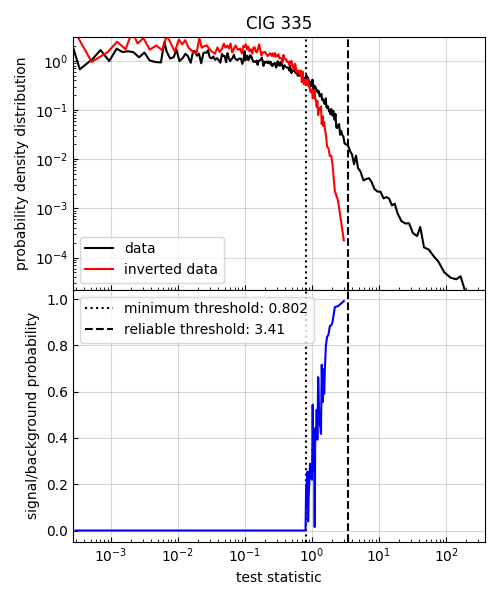

In [23]:
if plots:
    plt.close('test_statistic')
    fig = plt.figure('test_statistic', figsize=(5, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        th_line = axis.axvline(selection_threshold, c='k', ls=':')
        reliable_line = axis.axvline(reliable_threshold, c='k', ls='--')
    fig.set_tight_layout(True)


    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('probability density distribution')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(ts_inv.rho)/10, 3)
    ax[0, 0].plot(ts.x_rho, ts.rho, 'k-', label='data')
    ax[0, 0].plot(ts_inv.x_rho, ts_inv.rho, 'r-', label='inverted data')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('signal/background probability')
    ax[1, 0].plot(ts_inv.x_rho, ts_inv_reliability, 'b-')
    th_line.set_label(f'minimum threshold: {selection_threshold:.3g}')
    reliable_line.set_label(f'reliable threshold: {reliable_threshold:.3g}')
    ax[1, 0].legend()

    ax[-1, 0].set_xlim(ts_inv.sorted[0], ts_inv.sorted[-1]*np.sqrt(ts_inv.sorted[-1]/ts_inv.sorted[0]))
    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('test statistic')


In [24]:
ts_inv.sorted[-1], np.nanmax(test_stat_inv), np.std(data.sorted[:index_mode]), data.bg_std

(3.4074824433420217, 3.4074824433420217, 0.00068192807, 0.0011294282)

In [25]:
#true_overdensity = (test_stat > data.bg_std)
#true_overdensity = (test_stat > np.nanmax(test_stat_inv[1:]))
#true_overdensity = (test_stat > selection_threshold)
true_overdensity = (test_stat > reliable_threshold)


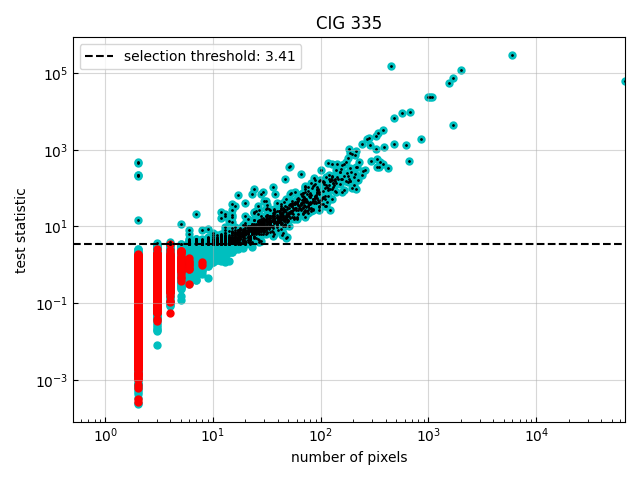

In [26]:
if plots:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    '''
    #ax[1, 0].axhline(delta_th, c='k', ls=':')
    ax[1, 0].scatter(area[1:], max_value[1:]-min_value[1:], s=25, c='c')
    ax[1, 0].scatter(area[true_overdensity],
                     max_value[true_overdensity]-min_value[true_overdensity], s=1, c='k')
    ax[1, 0].plot(np.exp(contrast_hull_x), contrast_hull_y, 'y-*')
    ax[1, 0].scatter(area_inv[1:], max_value_inv[1:]-min_value_inv[1:], s=1, c='r')
    ax[1, 0].set_xscale('log')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(np.min(contrast_hull_y[contrast_hull_y > 0])/10)
    '''

    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('test statistic')
    ax[0, 0].set_yscale('log')
    ax[0, 0].scatter(area[1:], test_stat[1:], s=25, c='c')
    ax[0, 0].scatter(area_inv[1:], test_stat_inv[1:], s=25, c='r')
    ax[0, 0].scatter(area[true_overdensity], test_stat[true_overdensity], s=1, c='k')
    #ax[0, 0].scatter(area_inv[good_hull], test_stat_inv[good_hull], s=5, c='y')
    #ax[0, 0].plot(np.exp(signal_hull_x), signal_hull_y, 'y*')
    #xx = np.linspace(signal_hull_x[0], signal_hull_x[-1], 100)
    #yy = np.interp(xx, signal_hull_x, signal_hull_y)
    #ax[0, 0].plot(np.exp(xx), yy, 'y-')
    dummy = np.logspace(.1, np.log10(np.max(area[1:])), 100)
    #ax[0, 0].plot(dummy, data.bg_std * (1 + 1/np.sqrt(dummy-1)), 'y-')
    #ax[0, 0].axhline(1, color='y', ls='--')
    ax[0, 0].axhline(reliable_threshold, color='k', ls='--', label=f'selection threshold: {reliable_threshold:.3g}')
    #ax[0, 0].axhline(reliable_threshold, color='k', ls='--', label=f'reliable threshold: {reliable_threshold:.3g}')
    #ax[0, 0].axhline(selection_threshold, color='k', ls=':', label=f'minimum threshold: {selection_threshold:.3g}')
    #ax[0, 0].set_ylim(.1*data.bg_std**2, np.max(test_stat))
    ax[0, 0].set_xlim(.5, np.max(area[1:]))
    ax[0, 0].legend()

    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels')

## 8. Clean-up

### prune HOT based on selection threshold

In [27]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

55093 yet to go
40667 yet to go
37736 yet to go
37447 yet to go
37433 yet to go
37432 yet to go


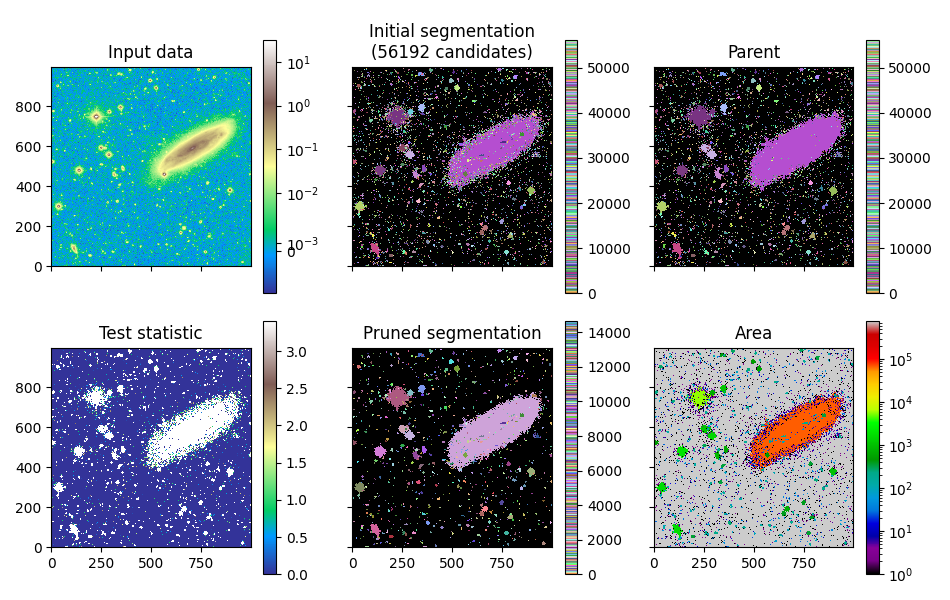

In [28]:
if plots and data_dimensionality == 2:
    segmentation = segm.SegmentationImage(label)
    pruned_segmentation = segm.SegmentationImage(pruned_labels[label])
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data.original,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        label,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    #ax[1, 0].set_title('Max S/N')
    ax[1, 0].set_title('Test statistic')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        test_stat[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm=colour_scale,
        vmax=np.nanmax(test_stat_inv[1:])
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('S/N threshold')
    im = ax[1, 1].imshow(
        #saddle_value[label],
        signal_to_noise_threshold[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [29]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

1100 objects after mode filtering


In [30]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [31]:
if plots and data_dimensionality == 2:
    final_selection = segm.SegmentationImage(final_labels)
    final_cmap = final_selection.make_cmap(seed=123)
    final_catalog = segm.SourceCatalog(data.original, final_selection)
    final_catalog.to_table()

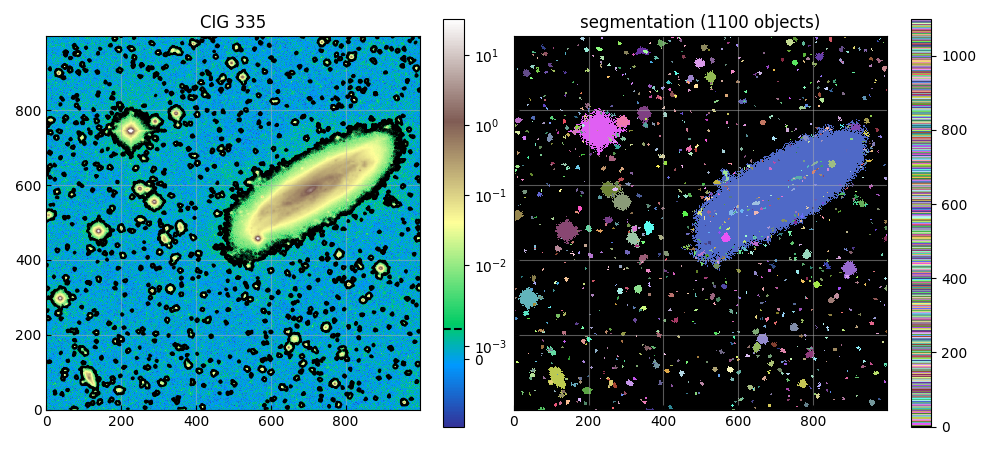

In [32]:
if plots and data_dimensionality == 2:
    plt.close('segmentation')
    fig = plt.figure('segmentation', figsize=(10, 4.5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    im = ax[0, 0].imshow(
        data.original,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    ax[0, 0].contour(final_labels, levels=[0.5], colors=['k'])
    #ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    #cb.ax.axhline(data.mode, c='k', ls=':')
    cb.ax.axhline(data.threshold, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    #ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')

    '''
    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    #ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_data.mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')
    '''
    ax[0, 1].set_title(f'segmentation ({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    #ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='+')
    cb = fig.colorbar(im, ax=ax[0, 1])
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


In [33]:
if plots and data_dimensionality == 3:
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data.original, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(data.threshold-data.mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data.original-data.mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data.mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(data.threshold-data.mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [34]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data.original[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-data.mode)
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [35]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


'\n'

In [36]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('outout/HOT_mask.fits', overwrite=True)
'''
'''


'\n'